In [1]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from scipy import stats

In [3]:
from train_test import make_parser, generate_data

parser = make_parser()
args = parser.parse_args([
    'chi2', '--data-seed=2314', '--type=radial', 'lawl'])
train, estop, val, test = generate_data(args)

This generates data as:
\begin{gather}
k \sim \mathrm{Uniform}[a, b] \\
X \mid k \sim \chi^2(k) \\
Y \mid X, k = X / k
\end{gather}

$\chi^2$ likelihood is
$$
p_X(x \mid k) = \frac{1}{2^{k/2} \Gamma(k/2)} x^{k/2 - 1} e^{-x/2}
.$$

So we have
$$
\Pr(Y \le y)
= \Pr(X/k \le y)
= \Pr(X \le k y)
,$$
and differentiating both sides by $y$,
$$
p_Y(y \mid k)
= k p_X(k y \mid k)
.$$

Thus $p_Y(\{y_i\} \mid k) = k p_X(\{k y_i\})$.

We could do it this way:
```python
def likelihood_indirect(X, k):
    return np.exp(stats.chi2(k).logpdf(X.ravel() * k).sum() + X.size * np.log(k))
```

But this version can vectorize across `k` and so is faster:

In [4]:
from scipy.special import gammaln
def likelihood(X, k):
    return np.exp( X.size * (
        np.log(k)
        - k/2 * np.log(2)
        - gammaln(k / 2)
        + (k/2 - 1) * (np.log(k) + np.log(X).mean())
        - k/2 * np.mean(X)
    ))

In [5]:
dfs = np.linspace(args.min_df, args.max_df, num=5000)

In [6]:
likelihoods = np.array([likelihood(bag, dfs) for bag in test])
posteriors = likelihoods / likelihoods.sum(axis=1, keepdims=True)
maps = dfs[posteriors.argmax(axis=1)]
means = posteriors.dot(dfs)

In [7]:
def interval(p, coverage=.95, center='mean'):
    if center == 'mean':
        i = dfs.searchsorted(dfs.dot(p))
    elif center == 'mode':
        i = p.argmax()
    else:
        i = dfs.searchsorted(center)
    # interval: covers [max(i - w, 0), min(i + w, len(p))]
    # want smallest w such that interval sum is >= coverage

    cumsum = np.r_[0, np.cumsum(p)]
    # sum(interval) == cumsum[min(i+w+1, len(p))] - cumsum[max(i-w, 0)]
    # find all sums:
    uppers = np.r_[cumsum[i+1:], np.repeat(cumsum[-1], i)]
    lowers = np.r_[cumsum[i:0:-1], np.repeat(0, len(p) - i)]
    w = np.searchsorted(uppers - lowers, coverage)

    return dfs[max(i - w, 0)], dfs[min(i + w + 1, len(p)) - 1]

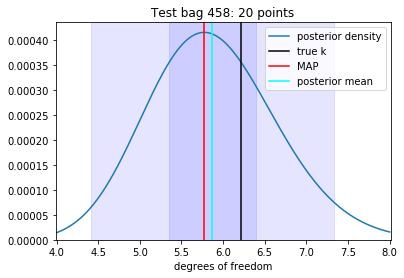

In [8]:
k = np.random.choice((test.n_pts == 20).nonzero()[0])
plt.plot(dfs, posteriors[k], label='posterior density')
plt.axvline(test.y[k], color='k', label='true k')
plt.axvline(maps[k], color='red', label='MAP')
plt.axvline(means[k], color='cyan', label='posterior mean')
plt.legend(loc='best')

ylim = [0, plt.ylim()[1]]
plt.fill_betweenx(ylim, *interval(posteriors[k], .95), alpha=.1, color='b')
plt.fill_betweenx(ylim, *interval(posteriors[k], .5), alpha=.1, color='b')
plt.xlim(4-.01, 8+.01)
plt.ylim(*ylim)
plt.title("Test bag {}: {} points".format(k, test.n_pts[k]))
plt.xlabel('degrees of freedom')

In [9]:
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
mean_squared_error(test.y, means), mean_squared_error(test.y, maps)

(0.19545174588520353, 0.23819838382754047)

In [11]:
r2_score(test.y, means), r2_score(test.y, maps)

(0.85111219306412567, 0.8185494080744512)

In [12]:
# Mean predictive log likelihood (essentially entropy)
inds = np.searchsorted(dfs, test.y)
np.mean(np.log(posteriors[xrange(posteriors.shape[0]), inds]))

-7.609651595881763

In [13]:
mean_coverage = []
map_coverage = []
for p, y in zip(posteriors, test.y):
    lo, hi = interval(p, .95, center='mean')
    mean_coverage.append(lo < y and y < hi)
    
    lo, hi = interval(p, .95, center='mode')
    map_coverage.append(lo < y and y < hi)
np.mean(mean_coverage), np.mean(map_coverage)

(0.93899999999999995, 0.93700000000000006)

In [14]:
mean_coverage = []
map_coverage = []
for p, y in zip(posteriors, test.y):
    lo, hi = interval(p, .75, center='mean')
    mean_coverage.append(lo < y and y < hi)
    
    lo, hi = interval(p, .75, center='mode')
    map_coverage.append(lo < y and y < hi)
np.mean(mean_coverage), np.mean(map_coverage)

(0.75, 0.73499999999999999)

In [15]:
with np.load('chi2_blr/results.npz') as d:
    print(d['test_mse'], d['test_r2'])

(array(0.30731824009471187), array(0.7744315775301602))


In [16]:
with np.load('chi2_mmd_krr_linear/results.npz') as d:
    print(d['test_mse'], d['test_r2'])

(array(0.2584721083915698), array(0.8041195173734577))
